In [315]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Import necessary libraries
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-of-amharic-language-texts/tweets.csv
/kaggle/input/sentiment-analysis-of-amharic-language-texts/users.csv
/kaggle/input/sentiment-analysis-of-amharic-language-texts/attributes.pdf


In [316]:
# Download nltk datasets if needed
nltk.download('stopwords')  
nltk.download('punkt')  # Ensure you download punkt for tokenization


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [317]:
# Load the datasets
tweets = pd.read_csv('/kaggle/input/sentiment-analysis-of-amharic-language-texts/tweets.csv', encoding='ISO-8859-1')
users = pd.read_csv('/kaggle/input/sentiment-analysis-of-amharic-language-texts/users.csv', encoding='ISO-8859-1')


In [318]:
#look 5 row of data 
tweets.head()

,community_note,created_at,edits_remaining,favorite_count,full_text,has_card,has_community_notes,hashtags,id,in_reply_to,...,quote_count,reply_count,retweet_count,retweeted_tweet,thumbnail_title,thumbnail_url,urls,user,view_count,view_count_state
0,NaN,Thu Oct 03 09:58:09 +0000 2024,5.0,6578,The alliance of the Sahel States will be a sta...,False,NaN,NaN,1841779764471685388,NaN,...,63,146,1419,NaN,NaN,NaN,NaN,1201055889073082368,78249,EnabledWithCount
1,NaN,Wed Oct 02 20:53:06 +0000 2024,5.0,2851,"Wizkid on Puma: ""But the budget they had for A...",False,NaN,NaN,1841582200321651113,NaN,...,3,96,374,NaN,NaN,NaN,NaN,1174799260228997120,56685,EnabledWithCount
2,NaN,Thu Oct 03 11:34:13 +0000 2024,5.0,1031,Chelsea fans in Africa are crazy https://t.co/...,False,NaN,NaN,1841803942939726089,NaN,...,4,38,134,NaN,NaN,NaN,NaN,1011730011265687552,25978,EnabledWithCount
3,NaN,Thu Oct 03 14:46:44 +0000 2024,5.0,1909,Chris Brown sold out 95k capacity FNB stadium ...,False,NaN,NaN,1841852392305733803,NaN,...,11,13,199,NaN,NaN,NaN,NaN,1522576405296517120,33364,EnabledWithCount
4,NaN,Fri Oct 04 10:30:10 +0000 2024,5.0,6560,Wizkid is the first African Artiste to have a ...,False,NaN,NaN,1842150212992733326,NaN,...,37,143,1651,NaN,NaN,NaN,NaN,129009730,189673,EnabledWithCount


# Data Preprocessing

In [319]:
tweets.shape

(1365, 28)

In [320]:
tweets.isnull().sum()

community_note         1360
created_at                0
edits_remaining          33
favorite_count            0
full_text                 0
has_card                  0
has_community_notes    1365
hashtags                894
id                        0
in_reply_to            1233
is_quote_status           0
is_translatable           0
lang                      0
media                   199
place                  1361
poll                   1365
possibly_sensitive      108
quote                  1323
quote_count               0
reply_count               0
retweet_count             0
retweeted_tweet        1365
thumbnail_title        1281
thumbnail_url          1282
urls                   1204
user                      0
view_count                0
view_count_state          0
dtype: int64

In [321]:
tweets.columns

Index(['community_note', 'created_at', 'edits_remaining', 'favorite_count',
       'full_text', 'has_card', 'has_community_notes', 'hashtags', 'id',
       'in_reply_to', 'is_quote_status', 'is_translatable', 'lang', 'media',
       'place', 'poll', 'possibly_sensitive', 'quote', 'quote_count',
       'reply_count', 'retweet_count', 'retweeted_tweet', 'thumbnail_title',
       'thumbnail_url', 'urls', 'user', 'view_count', 'view_count_state'],
      dtype='object')

# from tweets columns I use two columns **favorite_count and  full_text**  I use favorite_count becuase I don`t have label or target so I  Create a simple sentiment label based on favorite_count  

In [322]:
tweets['favorite_count']

0       6578
1       2851
2       1031
3       1909
4       6560
        ... 
1360       2
1361       3
1362       5
1363       6
1364       2
Name: favorite_count, Length: 1365, dtype: int64

In [323]:
tweets['full_text']

0       The alliance of the Sahel States will be a sta...
1       Wizkid on Puma: "But the budget they had for A...
2       Chelsea fans in Africa are crazy https://t.co/...
3       Chris Brown sold out 95k capacity FNB stadium ...
4       Wizkid is the first African Artiste to have a ...
                              ...                        
1360    @qomche_killer @HodanHomes Typical Oromo slave...
1361    @HodanHomes No matter what yall modafuckas tr...
1362    @ShabelleMedia We dont trust oromo. There is n...
1363    Fascist Abiy Ahmeds regime extends its brutal...
1364        @Bulaale13 Dont like to talk to Oromo slaves
Name: full_text, Length: 1365, dtype: object

In [324]:
# Create a simple sentiment label based on favorite_count
def assign_sentiment(favorite_count):
    if favorite_count > 10:
        return 1  # Positive
    elif favorite_count > 0:
        return 0  # Neutral
    else:
        return -1  # Negative

tweets['sentiment'] = tweets['favorite_count'].apply(assign_sentiment)
tweets['sentiment'].value_counts()

sentiment
 1    838
 0    467
-1     60
Name: count, dtype: int64

In [325]:
# Romove Noise
def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\n', ' ', text)  # Remove new lines
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text
# Apply text cleaning
tweets['clean_text'] = tweets['full_text'].apply(clean_text)



In [326]:
tweets['clean_text']

0       The alliance of the Sahel States will be a sta...
1       Wizkid on Puma But the budget they had for Afr...
2                       Chelsea fans in Africa are crazy 
3       Chris Brown sold out 95k capacity FNB stadium ...
4       Wizkid is the first African Artiste to have a ...
                              ...                        
1360      Typical Oromo slave stealing the cultures of...
1361     No matter what yall modafuckas try Amhara and...
1362     We dont trust oromo There is no reason that t...
1363    Fascist Abiy Ahmeds regime extends its brutal ...
1364                    Dont like to talk to Oromo slaves
Name: clean_text, Length: 1365, dtype: object

In [327]:
# Define custom Amharic stopwords
amharic_stopwords = [
    'እና', 'ወይም', 'እንደ', 'ይህ', 'ነው', 'አሁን', 'ላይ', 'እስከ', 'ወስን', 'ማንኛውም', 'እነሱ', 'ስለሆነ'
]

In [328]:
# Remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in amharic_stopwords])

tweets['clean_text'] = tweets['clean_text'].apply(remove_stopwords)


In [329]:
# Normalize text function
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text  # Lowercase and remove digits

tweets['normalized_text'] = tweets['clean_text'].apply(normalize_text)


In [330]:
tweets['normalized_text']


0       the alliance of the sahel states will be a sta...
1       wizkid on puma but the budget they had for afr...
2                        chelsea fans in africa are crazy
3       chris brown sold out k capacity fnb stadium in...
4       wizkid is the first african artiste to have a ...
                              ...                        
1360    typical oromo slave stealing the cultures of w...
1361    no matter what yall modafuckas try amhara and ...
1362    we dont trust oromo there is no reason that th...
1363    fascist abiy ahmeds regime extends its brutal ...
1364                    dont like to talk to oromo slaves
Name: normalized_text, Length: 1365, dtype: object

In [331]:
# Stemming function
stemmer = PorterStemmer()

def stem_text(text):
    words = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in words])

# Apply stemming
tweets['stemmed_text'] = tweets['normalized_text'].apply(stem_text)


In [332]:
tweets['stemmed_text']

0       the allianc of the sahel state will be a start...
1       wizkid on puma but the budget they had for afr...
2                         chelsea fan in africa are crazi
3       chri brown sold out k capac fnb stadium in sou...
4       wizkid is the first african artist to have a n...
                              ...                        
1360    typic oromo slave steal the cultur of whatev e...
1361    no matter what yall modafucka tri amhara and o...
1362    we dont trust oromo there is no reason that th...
1363    fascist abiy ahm regim extend it brutal reach ...
1364                     dont like to talk to oromo slave
Name: stemmed_text, Length: 1365, dtype: object

In [333]:
# Split the data into training and testing sets
X = tweets['stemmed_text']
y = tweets['sentiment']

In [334]:
X.shape,y.shape


((1365,), (1365,))

In [335]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words=amharic_stopwords)
X_tfidf = tfidf.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [336]:
print(X_train)
print(X_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 26766 stored elements and shape (1092, 5000)>
  Coords	Values
  (0, 2604)	0.4103519789366811
  (0, 4179)	0.4103519789366811
  (0, 3655)	0.4103519789366811
  (0, 450)	0.38824561832575405
  (0, 1881)	0.2905571115646934
  (0, 3385)	0.18850459684161047
  (0, 4578)	0.3347698327865474
  (0, 2265)	0.3347698327865474
  (1, 1019)	0.32960226009344024
  (1, 2488)	0.24026039421566492
  (1, 3970)	0.30029366243716293
  (1, 1461)	0.3205112250781597
  (1, 549)	0.2513869218413811
  (1, 946)	0.25350905677551494
  (1, 1053)	0.30616663610076716
  (1, 26)	0.20825586191298437
  (1, 2085)	0.22468456626891933
  (1, 4639)	0.21188383574724845
  (1, 2664)	0.26573151081877366
  (1, 2378)	0.41160345212690536
  (1, 241)	0.10007612027961289
  (1, 2363)	0.10807991877711885
  (1, 3243)	0.13804989706915743
  (2, 3162)	0.35184819579439286
  (2, 31)	0.35184819579439286
  :	:
  (1090, 1737)	0.30640492634679756
  (1090, 4770)	0.14085934481720658
  (1090, 660)	0.

In [337]:
# # Train a Naive Bayes classifier
# nb_model = MultinomialNB()
# nb_model.fit(X_train, y_train)

# # Predict on the test set for Naive Bayes
# y_pred_nb = nb_model.predict(X_test)

# # Evaluate Naive Bayes model performance
# print("Naive Bayes Classifier:")
# print(classification_report(y_test, y_pred_nb))
# print("Accuracy:", accuracy_score(y_test, y_pred_nb))


In [342]:
# Train a Logistic Regression classifier
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Predict on the test set for Logistic Regression
X_test_prediction = lr_model.predict(X_test)
X_train_Prediction = lr_model.predict(X_train)

# Evaluate the Logistic Regression model
print("Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_lr))
print("X_train_prediction accuracy", accuracy_score(y_train,X_train_Prediction))
print("X_test_prediction accuracy:", accuracy_score(y_test, X_test_prediction))

Logistic Regression Classifier:
              precision    recall  f1-score   support

          -1       1.00      0.07      0.13        14
           0       0.74      0.61      0.67        87
           1       0.77      0.90      0.83       172

    accuracy                           0.76       273
   macro avg       0.84      0.53      0.54       273
weighted avg       0.77      0.76      0.74       273

X_train_prediction accuracy 0.8974358974358975
X_test_prediction accuracy: 0.7619047619047619


X_train_prediction accuracy 0.8974358974358975
X_test_prediction accuracy: 0.7619047619047619
 they are almost the same 

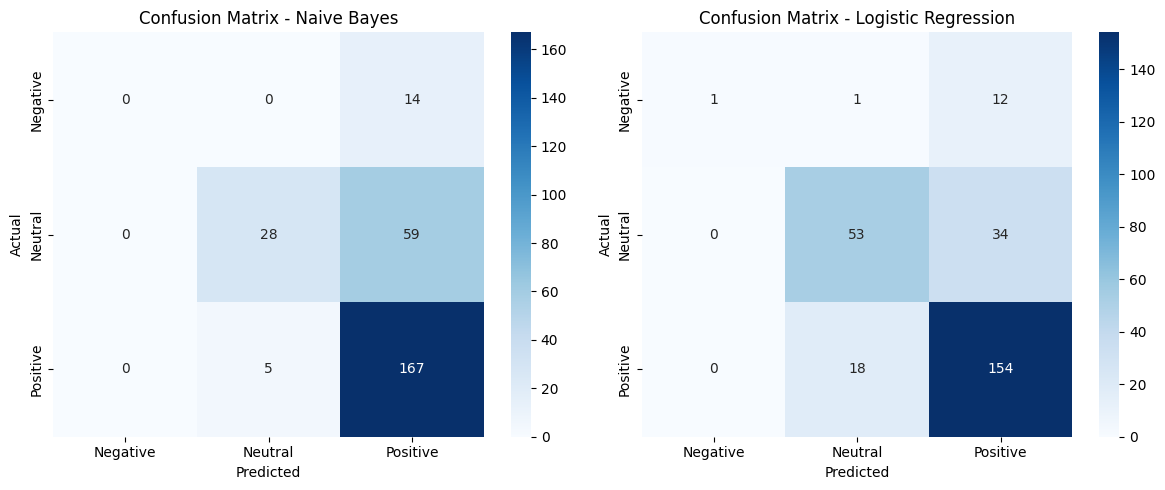

In [339]:
# Confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create subplots for both models

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Confusion Matrix - Naive Bayes')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[1], 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1].set_title('Confusion Matrix - Logistic Regression')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
